El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_4151745/699112975.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'

# Load data

In [3]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, "snapshot")
print(dfv.info())
print(dfp.info())

Warning, removing 116560 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1943 entries, 0 to 2193
Data columns (total 13 columns):
 #   Column          

In [4]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0xe7af1c70f8f089c4c3bd71999692c6c5a15d9e2a,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 12:28:01,1
1,0xc54a6c3778016b06cbd126ccc3b5bc06c5f666fb,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 02:16:23,1
2,0xd82d005e8f8d5385db40ba23884a5c967bb1e8af,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 00:38:22,1
3,0xf4c64db66ffb301985f5ecd85c8f3f9c02f2659d,b86aa059-3d31-5d41-a472-70962816f779,2021-12-16 18:47:08,1
4,0xd5e9ef1cedad0d135d543d286a2c190b16cbb89e,b86aa059-3d31-5d41-a472-70962816f779,2021-12-16 18:32:15,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                         1943
mean     8 days 02:38:36.006176016
std      3 days 01:17:27.822183473
min                5 days 00:00:00
25%                7 days 00:00:00
50%                7 days 00:00:00
75%                7 days 00:00:00
max               14 days 00:00:00
dtype: object

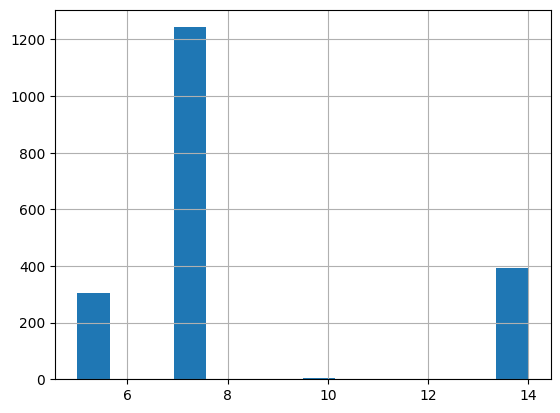

In [5]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

## What day or the week are proposals created

Monday       346
Tuesday      326
Wednesday    324
Thursday     305
Friday       258
Saturday     199
Sunday       185
Name: start, dtype: int64

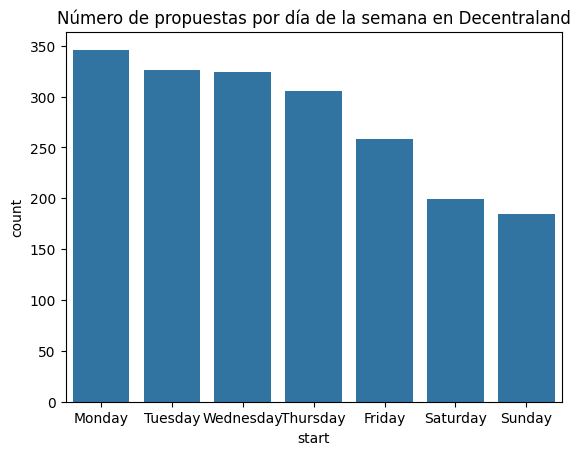

In [6]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Tuesday      17573
Friday       17101
Monday       17059
Thursday     16952
Wednesday    16784
Saturday     16496
Sunday       14595
Name: date, dtype: int64

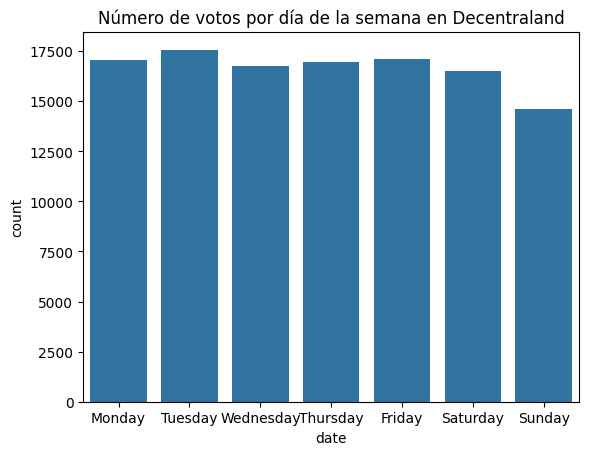

In [7]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

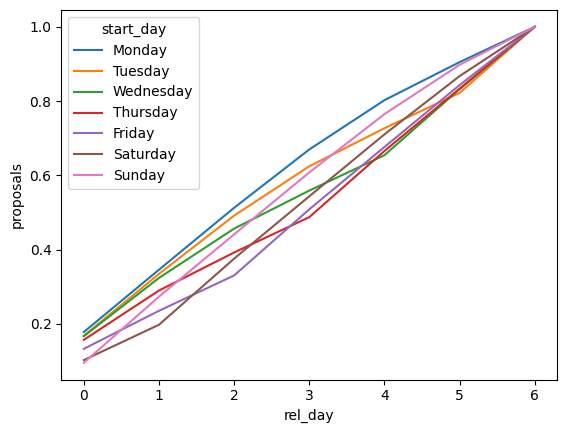

In [8]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

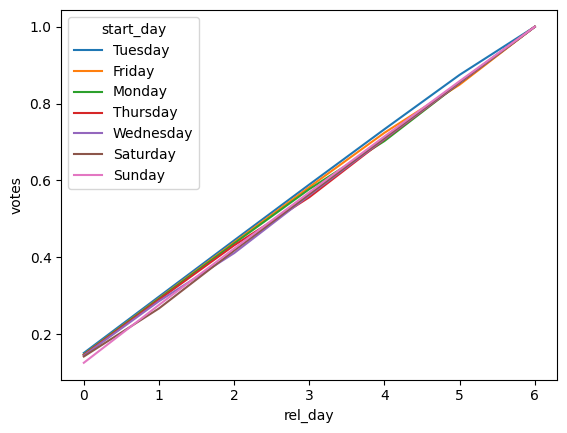

In [9]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

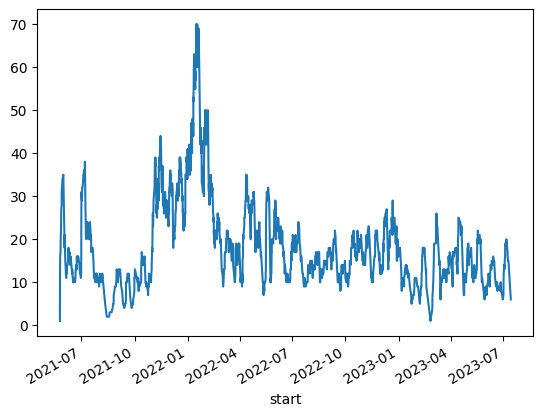

In [10]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [11]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                            W-SUN        W-MON        W-TUE  \
votes in open proposals (train) count   111.000000   112.000000   112.000000   
                                mean    967.378378   974.151786   961.535714   
                                std     799.886811   788.535445   793.762632   
                                min       9.000000     0.000000    19.000000   
                                50%     765.000000   777.500000   763.500000   
                                max    4449.000000  4137.000000  3816.000000   
users in open proposals (train) count   111.000000   112.000000   112.000000   
                                mean    297.405405   300.348214   298.348214   
                                std     150.075640   153.203081   146.963114   
                                min       8.000000     0.000000    17.000000   
                                50%     302.000000   299.500000   294.000000   
                                max     755.000000   735.000000   638.000000   
open proposals                  count   111.000000   112.000000   112.000000   
                                mean     20.243243    19.857143    19.910714   
                                std      10.907225    11.211205    10.934328   
                                min       2.000000     0.000000     2.000000   
                                50%      18.000000    17.500000    17.500000   
                                max      70.000000    70.000000    66.000000   
votes in test                   count   111.000000   112.000000   112.000000   
                                mean    274.801802   241.580357   250.803571   
                                std     222.564345   185.909628   185.043401   
                                min      13.000000     0.000000     4.000000   
                                50%     212.000000   185.500000   202.500000   
                                max    1266.000000   818.000000   870.000000   
users in test                   count   111.000000   112.000000   112.000000   
                                mean    105.576577    98.741071   103.544643   
                                std      66.273888    62.698297    63.034223   
                                min      12.000000     0.000000     4.000000   
                                50%      94.000000    93.500000   104.500000   
                                max     327.000000   312.000000   351.000000   
vpp test                        count   111.000000   111.000000   112.000000   
                                mean     16.085854    14.476811    15.437437   
                                std      15.221782    13.727263    15.109899   
                                min       1.529412     1.772727     1.533333   
                                50%      10.857143    10.250000    10.456140   
                                max      75.363636    81.800000    90.500000   
vpu test                        count   111.000000   111.000000   112.000000   
                                mean      2.443482     2.316262     2.306687   
                                std       0.869001     0.784109     0.733827   
                                min       1.000000     1.125000     1.000000   
                                50%       2.254545     2.128205     2.188882   
                                max       5.197674     5.603774     4.106383   

f                                            W-WED        W-THU        W-SAT  
votes in open proposals (train) count   112.000000   112.000000   111.000000  
                                mean    936.723214   912.607143   928.981982  
                                std     753.658084   694.516766   740.879870  
                                min      21.000000    22.000000     5.000000  
                                50%     723.500000   739.000000   726.000000  
                                max    3752.000000  3322.000000  3699.000000  
users 

In [12]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_4151745/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),107379.000000,109105.000000,107692.000000,104913.00000,102212.000000,103117.000000
users in open proposals (train),33012.000000,33639.000000,33415.000000,32979.00000,33144.000000,32373.000000
open proposals,2247.000000,2224.000000,2230.000000,2236.00000,2243.000000,2260.000000
votes in test,30503.000000,27057.000000,28090.000000,31292.00000,32438.000000,33170.000000
users in test,11719.000000,11059.000000,11597.000000,12171.00000,12143.000000,12345.000000
vpp test,1785.529830,1606.926065,1728.992980,1936.64575,1973.541218,1907.172916
vpu test,271.226449,257.105070,258.348906,267.80475,276.598500,278.981847


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [13]:
from recommenders.datasets.pandas_df_utils import filter_by

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""
def getBaselineRecommendations(train: pd.DataFrame, users, proposals, k: int = 5, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    # bestVotes = bestVotes[bestVotes.index.isin(proposals)]

    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    # Avoid recommending already voted proposals (they wont be in the test set)
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [14]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [15]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [16]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-08-04 00:57:07)  =====
Currently open proposals: 9
Train votes in open proposals: 142
Test votes in open proposals:   48

===== Training on fold 1 (t: 2021-10-14 16:08:30)  =====
Currently open proposals: 14
Train votes in open proposals: 158
Test votes in open proposals:  132

===== Training on fold 2 (t: 2021-12-25 02:40:07)  =====
Currently open proposals: 29
Train votes in open proposals: 756
Test votes in open proposals:   99

===== Training on fold 3 (t: 2022-03-06 19:14:35)  =====
Currently open proposals: 18
Train votes in open proposals: 489
Test votes in open proposals:  157

===== Training on fold 4 (t: 2022-05-17 08:44:54)  =====
Currently open proposals: 33
Train votes in open proposals: 578
Test votes in open proposals:  283

===== Training on fold 5 (t: 2022-07-27 20:58:07)  =====
Currently open proposals: 11
Train votes in open proposals: 399
Test votes in open proposals:  219

===== Training on fold 6 (t: 2022-10-07 11:03:04)  =====
Cu

In [17]:
from src import paths

pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.145534,0.294985,0.233064,0.376813,0.136072,0.396818,0.290771,0.672871,0.113898,0.439916,0.311207,0.804765,0.376084,0.211757
std,0.074635,0.202287,0.186175,0.274633,0.045895,0.165773,0.168256,0.264062,0.038221,0.152683,0.164084,0.213010,0.092464,0.063021
min,0.013223,0.034569,0.030151,0.038666,0.057447,0.175352,0.090313,0.308951,0.059574,0.259346,0.126316,0.501199,0.214876,0.109091
25%,0.092749,0.175023,0.097710,0.271048,0.105087,0.313149,0.154307,0.449144,0.091193,0.329317,0.175903,0.653276,0.345361,0.183017
50%,0.153866,0.274016,0.197997,0.324772,0.148637,0.383932,0.297207,0.640202,0.113628,0.425566,0.313713,0.846912,0.369055,0.209502
75%,0.194445,0.341228,0.311422,0.372638,0.172823,0.443058,0.333320,0.915370,0.127746,0.515608,0.370492,1.000000,0.448175,0.254412
max,0.268333,0.747259,0.659491,1.000000,0.190909,0.747259,0.659491,1.000000,0.190909,0.747259,0.659491,1.000000,0.497674,0.308721


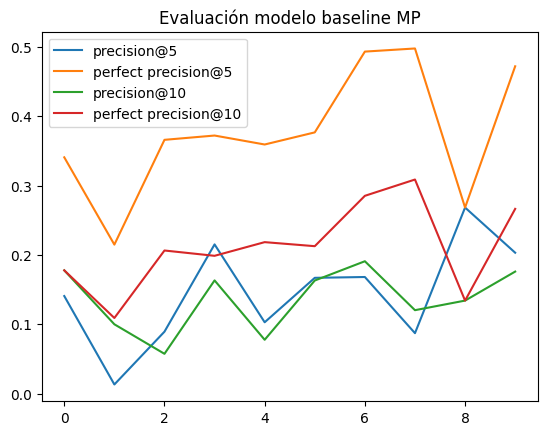

In [18]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,0.376084,1.0,0.970333,0.970333,0.211757,1.0,0.995063,0.995063,0.144764,1.0,0.998419,0.998419
std,0.092464,0.0,0.024256,0.024256,0.063021,0.0,0.008644,0.008644,0.044922,0.0,0.004339,0.004339
min,0.214876,1.0,0.923537,0.923537,0.109091,1.0,0.973738,0.973738,0.072727,1.0,0.986203,0.986203
25%,0.345361,1.0,0.956418,0.956418,0.183017,1.0,0.995568,0.995568,0.122011,1.0,1.000000,1.000000
50%,0.369055,1.0,0.971791,0.971791,0.209502,1.0,0.999483,0.999483,0.141087,1.0,1.000000,1.000000
75%,0.448175,1.0,0.988547,0.988547,0.254412,1.0,1.000000,1.000000,0.177015,1.0,1.000000,1.000000
max,0.497674,1.0,1.000000,1.000000,0.308721,1.0,1.000000,1.000000,0.217054,1.0,1.000000,1.000000


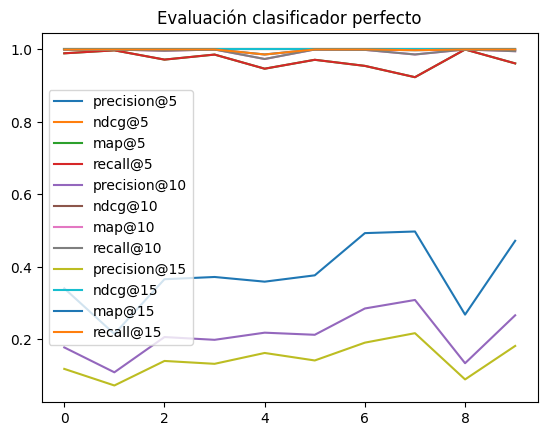

In [19]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [20]:
from tqdm.autonotebook import tqdm

In [21]:
from functools import partial

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/112 [00:00<?, ?it/s]

In [22]:
{ k:len(v) for k,v in metrics.items() }

{'t': 112,
 'precision@5': 112,
 'ndcg@5': 112,
 'map@5': 112,
 'recall@5': 112,
 'precision@10': 112,
 'ndcg@10': 112,
 'map@10': 112,
 'recall@10': 112,
 'precision@15': 112,
 'ndcg@15': 112,
 'map@15': 112,
 'recall@15': 112}

In [23]:
# Save the data
from pathlib import Path
baseline_folder = Path('./data/baseline/')
baseline_folder.mkdir(exist_ok=True)

pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.171351,0.307683,0.231989,0.390649,0.145013,0.386642,0.285322,0.612733,0.124566,0.436988,0.310276,0.773680,0.399913,0.231880
std,0.092382,0.169390,0.153367,0.231843,0.067447,0.173835,0.161703,0.268675,0.052394,0.162105,0.157851,0.248329,0.099620,0.082864
min,0.015190,0.022837,0.011798,0.027345,0.019531,0.053262,0.024085,0.059910,0.019900,0.071251,0.028937,0.125653,0.200000,0.100000
25%,0.106137,0.190360,0.122524,0.238339,0.103048,0.271685,0.168321,0.398486,0.087153,0.331951,0.201483,0.596864,0.335057,0.178149
50%,0.161117,0.284600,0.216940,0.334844,0.138540,0.375359,0.261067,0.599665,0.121580,0.430679,0.288049,0.877762,0.401672,0.230183
75%,0.219834,0.414052,0.329167,0.520668,0.174521,0.490857,0.387031,0.832005,0.155674,0.544337,0.411624,1.000000,0.463119,0.273965
max,0.509091,0.938488,0.916667,1.000000,0.352991,0.938488,0.916667,1.000000,0.316524,0.938488,0.916667,1.000000,0.751220,0.657317


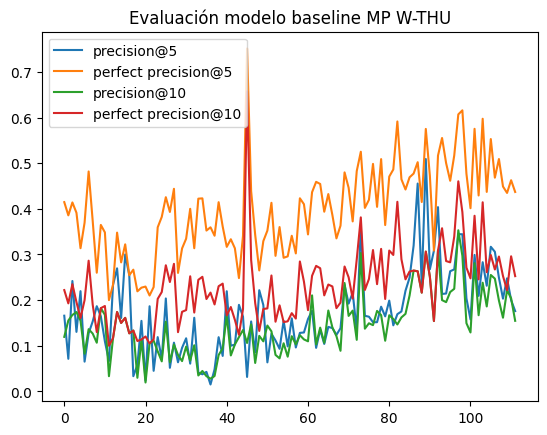

In [24]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title=f'Evaluación modelo baseline MP {SPLITS_FREQ}')
mdf.describe()

In [25]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.340741,1.0,0.989418,0.989418,0.177778,1.0,1.000000,1.000000,0.118519,1.0,1.000000,1.000000
1,0.214876,1.0,0.997639,0.997639,0.109091,1.0,1.000000,1.000000,0.072727,1.0,1.000000,1.000000
2,0.365957,1.0,0.972053,0.972053,0.206383,1.0,0.996454,0.996454,0.140426,1.0,1.000000,1.000000
3,0.372152,1.0,0.985935,0.985935,0.198734,1.0,1.000000,1.000000,0.132489,1.0,1.000000,1.000000
4,0.359223,1.0,0.946956,0.946956,0.218447,1.0,0.973738,0.973738,0.162460,1.0,0.986203,0.986203
5,0.376699,1.0,0.971529,0.971529,0.212621,1.0,1.000000,1.000000,0.141748,1.0,1.000000,1.000000
6,0.493182,1.0,0.954705,0.954705,0.285227,1.0,0.998967,0.998967,0.190909,1.0,1.000000,1.000000
7,0.497674,1.0,0.923537,0.923537,0.308721,1.0,0.986194,0.986194,0.217054,1.0,0.997984,0.997984
8,0.268333,1.0,1.000000,1.000000,0.134167,1.0,1.000000,1.000000,0.089444,1.0,1.000000,1.000000
9,0.472000,1.0,0.961557,0.961557,0.266400,1.0,0.995273,0.995273,0.181867,1.0,1.000000,1.000000


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000,112.0,112.000000,112.000000
mean,0.399913,1.0,0.959734,0.959734,0.231880,1.0,0.991646,0.991646,0.161086,1.0,0.998036,0.998036
std,0.099620,0.0,0.045040,0.045040,0.082864,0.0,0.012560,0.012560,0.062663,0.0,0.004154,0.004154
min,0.200000,1.0,0.686640,0.686640,0.100000,1.0,0.939869,0.939869,0.066667,1.0,0.974518,0.974518
25%,0.335057,1.0,0.945798,0.945798,0.178149,1.0,0.987840,0.987840,0.120964,1.0,0.998280,0.998280
50%,0.401672,1.0,0.969731,0.969731,0.230183,1.0,0.997970,0.997970,0.156789,1.0,1.000000,1.000000
75%,0.463119,1.0,0.990906,0.990906,0.273965,1.0,1.000000,1.000000,0.190783,1.0,1.000000,1.000000
max,0.751220,1.0,1.000000,1.000000,0.657317,1.0,1.000000,1.000000,0.482927,1.0,1.000000,1.000000


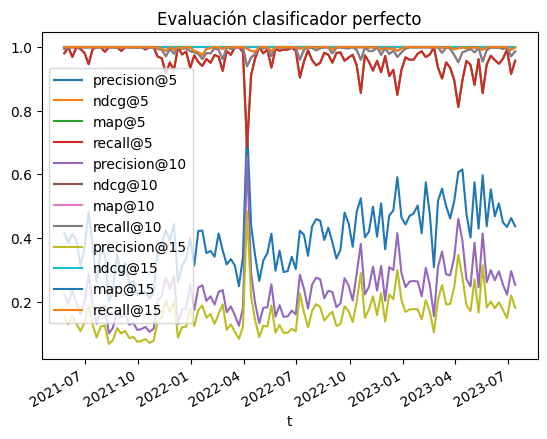

In [26]:
pmdf = pd.DataFrame(perfectmetrics).set_index('t')

pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()